# Neural & Behavioral Modeling - Week 10 (Exercises)
by Cheng-Kuang, Wu (r10922186@ntu.edu.tw)

In [ ]:
# Upgrade PyTorch if necessary:
! conda install -y pytorch-cpu torchvision-cpu -c pytorch

In [1]:
%config IPCompleter.greedy=True 
%matplotlib inline
from matplotlib.pyplot import *
from IPython.display import *
import numpy as np

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-fi99etus because the default path (/home/ckwu/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
# Check GPU status:
import torch as t
print('PyTorch version:',t.__version__)
if(t.cuda.is_available()):
    for i in range(t.cuda.device_count()):
        print('Device ',i,':',t.cuda.get_device_name(i))
    print('Current: Device ',t.cuda.current_device())
    t.backends.cudnn.benchmark = True 
else:
    print('No GPU')

PyTorch version: 1.11.0
Device  0 : GeForce RTX 3090
Device  1 : GeForce RTX 3090
Current: Device  0


## 1 Tuning the performance of a neural net (8 points)

### 1.1 Problem
In the section 4.1 of model_10_examples.ipynb, the neural network implemented in NumPy with two hidden layers could reach 90% classification accuracy on the MNIST training data only within 3 learning epochs:

<pre>
model=MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100], output_size=10,
                          weight_init_std=weight_init_std, use_batchnorm=True, use_dropout=True)
</pre>

However, in the section 4.2, a similar network implemented in PyTorch did not reached 90% clasification accuracy model on the MNIST training data: 

<pre>
model = t.nn.Sequential(
    t.nn.Linear(D_in, H),
    #t.nn.BatchNorm1d(H),
    t.nn.ReLU(),
    #t.nn.Dropout(p=0.5),
    #t.nn.Linear(H, H),
    #t.nn.BatchNorm1d(H),
    #ct.nn.ReLU(),
    #t.nn.Dropout(p=0.5),
    t.nn.Linear(H, D_out),
    t.nn.Softmax()
)
</pre>

Your goal is to do whatever you can to help the PyTorch net reach 90% classification accuracy on the MNIST training data within 50 or less epochs.

### 1.2 Tips

First try to eliminate the differences between the NumPy net and the PyTorch net:

(1) The PyTorch version did not use 50% Dropout.

(2) The PyTorch used Adam with a learning rate of 1e-4 as an optimizer instead of SGD with a learning rate of 1e-2.

(3) The PyTroch version did not use shuffled batch (100 samples) in each training epoch.


(4)If removal of the above differences does not help, look for other differences or do whatever you can to accelerate learning of the PyTorch net.

<b>(5) Do not waste your time on checking out training results after 50 epochs! They have nothing to do with your goal here.</b>

### 1.3 Your codes and discussions

#### 1.3.1 The MNIST dataset

In [3]:
# Download the dataset:
import urllib.request
urllib.request.urlretrieve('https://github.com/mnielsen/neural-networks-and-deep-learning/raw/master/data/mnist.pkl.gz','mnist.pkl.gz')

('mnist.pkl.gz', <http.client.HTTPMessage at 0x7fe2428007f0>)

/tmp/ipykernel_4988/4169240449.py:4: DeprecationWarning: invalid escape sequence '\>'
  train_set, valid_set, test_set = pickle.load(f,encoding='unicode-escape')
/tmp/ipykernel_4988/4169240449.py:4: DeprecationWarning: invalid escape sequence '\?'
  train_set, valid_set, test_set = pickle.load(f,encoding='unicode-escape')


(50000, 784) (50000,) (10000, 784) (10000,)
0.0 0.99609375 0 9


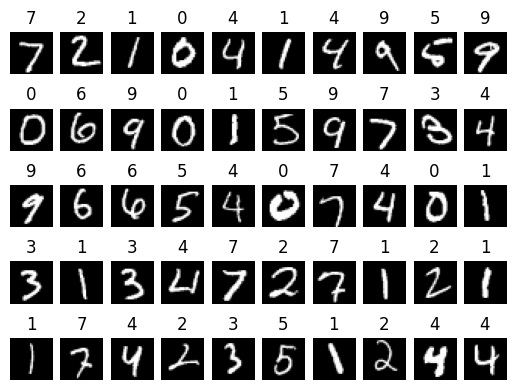

In [4]:
# Load the dataset:
import pickle, gzip
f = gzip.open('mnist.pkl.gz','rb')
train_set, valid_set, test_set = pickle.load(f,encoding='unicode-escape')
f.close()
x_train,y_train=train_set[0],train_set[1]
x_valid,y_valid=valid_set[0],valid_set[1]
x_test,y_test=test_set[0],test_set[1]

# Examine the dataset:
print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)
print(np.min(x_train),np.max(x_train),np.min(y_train),np.max(y_train))
for i in range(50):
    subplot(5,10,i+1)
    imshow(x_test[i].reshape([28,28]),cmap='gray');
    title(str(y_test[i]));
    axis('off')
    
# Transform NumPy arrays to PyTorch tensors:
use_cuda=t.cuda.is_available()

X_train=t.from_numpy(x_train)
Y_train=t.from_numpy(y_train)
X_test=t.from_numpy(x_test)
Y_test=t.from_numpy(y_test)

if(use_cuda):
    X_train=X_train.cuda()
    Y_train=Y_train.cuda()
    X_test=X_test.cuda()
    Y_test=Y_test.cuda()

#### 1.3.2 Your systematic explorations

In [10]:
class CNNModel(t.nn.Module):

    def __init__(self):
        super(CNNModel, self).__init__()
        self.cnn = t.nn.Sequential(
            # Convolution 1
            t.nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=0),
            t.nn.BatchNorm2d(num_features=16),
            t.nn.ReLU(),
            # Max pool 1
            t.nn.MaxPool2d(kernel_size=2),
            # Convolution 2
            t.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=0),
            t.nn.BatchNorm2d(num_features=32),
            t.nn.ReLU(),
            # Max pool 2
            t.nn.MaxPool2d(kernel_size=2)
        )
        self.linear = t.nn.Linear(32 * 4 * 4, 10)
    
    def forward(self, x):
        # Convolution 1
        out = self.cnn(x)
        out = out.view(out.size(0), -1)
        # Linear function (readout)
        out = self.linear(out)
        return out

class Experiment(object):
    D_in, H, D_out = 784, 100, 10
    nepochs = 50

    def __init__(
        self,
        use_cuda: bool = True,
        add_dropouts: bool = False,
        learning_rate: float = 1e-4,
        use_cnn_model: bool = False
    ):
        self.use_cuda = use_cuda
        self.add_dropouts = add_dropouts
        self.use_cnn_model = use_cnn_model

        self.X_train, self.Y_train = self.load_train_data()

        if use_cnn_model:
            self.model = self.get_cnn_model()
        else:
            self.model = self.get_fc_model()
        self.loss_fn = t.nn.CrossEntropyLoss()
        self.optimizer = t.optim.Adam(self.model.parameters(), lr=learning_rate)

        if use_cuda:
            self.model = self.model.cuda()
            self.loss_fn = self.loss_fn.cuda()

    def load_train_data(self):
        f = gzip.open('mnist.pkl.gz','rb')
        train_set, _, _ = pickle.load(f, encoding='unicode-escape')
        f.close()
        x_train, y_train = train_set[0], train_set[1]
            
        # Transform NumPy arrays to PyTorch tensors:
        X_train = t.from_numpy(x_train)
        Y_train = t.from_numpy(y_train)

        if self.use_cuda:
            X_train = X_train.cuda()
            Y_train = Y_train.cuda()

        return X_train, Y_train
    
    def get_fc_model(self) -> t.nn.Module:
        D_in, H, D_out = self.D_in, self.H, self.D_out

        layer1 = [
            t.nn.Linear(D_in, H),
            t.nn.BatchNorm1d(H),
            t.nn.ReLU(),
        ]
        layer2 = [
            t.nn.Linear(H, H),
            t.nn.BatchNorm1d(H),
            t.nn.ReLU(),
        ]
        layer3 = [
            t.nn.Linear(H, D_out),
            t.nn.Softmax()
        ]
        if self.add_dropouts:
            layer1.append(t.nn.Dropout(p=0.5))
            layer2.append(t.nn.Dropout(p=0.5))

        layers = layer1 + layer2 + layer3
        model = t.nn.Sequential(*layers)
        return model

    def get_cnn_model(self) -> t.nn.Module:
        return CNNModel()

    def run(self) -> None:
        for i in range(self.nepochs + 1):
            # Forward pass:
            if self.use_cnn_model:
                self.X_train = self.X_train.view(self.X_train.shape[0], 1, 28, 28)
            
            Y_pred = self.model(self.X_train)
            loss = self.loss_fn(Y_pred, self.Y_train)
            
            # Zero the gradients before running the backward pass.
            self.model.zero_grad()

            # Backward pass:
            loss.backward()

            # Update the weights using gradient descent:
            self.optimizer.step()
            
        # Check final accuracy:
        Y_pred = self.model(self.X_train) # Y_pred.shape=[50000,10]
        Y_pred = t.max(Y_pred, 1)[1] # Y_pred.shape=[50000]
        print(f'Final accuracy @Epoch{i}: ',(Y_pred == self.Y_train).sum().item() / self.Y_train.shape[0])


print("Initial baseline:")
Experiment().run()

print("Attempt 1: add Dropouts")
Experiment(add_dropouts=True).run()

print("Attempt 2: adjust learning rate")
Experiment(learning_rate=1e-3).run()

print("Attempt 3: change to CNN architecture")
Experiment(use_cnn_model=True, learning_rate=1e-3).run()

Initial baseline:


/tmp/ipykernel_4988/1794802303.py:59: DeprecationWarning: invalid escape sequence '\>'
  train_set, _, _ = pickle.load(f, encoding='unicode-escape')
/tmp/ipykernel_4988/1794802303.py:59: DeprecationWarning: invalid escape sequence '\?'
  train_set, _, _ = pickle.load(f, encoding='unicode-escape')


Final accuracy @Epoch50:  0.7241
Attempt 1: add Dropouts
Final accuracy @Epoch50:  0.49814
Attempt 2: adjust learning rate
Final accuracy @Epoch50:  0.91514
Attempt 3: change to CNN architecture
Final accuracy @Epoch50:  0.95602
